In [1]:
## Imports

In [1]:
import xarray as xr

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgcm
from typing import Annotated
from xhistogram.xarray import histogram
from fastjmd95 import rho

In [2]:
print(xr.__version__)

2025.7.0


In [3]:
## Open the data

In [4]:
# data in persistent bucket
#target_url ='gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_renorm_48hr.zarr'
#target_url ='gs://leap-persistent/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr'

In [5]:
#hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})

In [6]:
#from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
#hist_ds = hist_ds.set_xindex('region_num', PandasIndex)

In [7]:
## Expectation values

In [8]:
def marginalize(pdf: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Integrate out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
       
    all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
    
    if isinstance(dims, str):
        dims = [dims]
    
    if dims is None:
        dims=all_bin_dims
    
    if any(d not in all_bin_dims for d in dims):
        raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")
    
    marginal_pdf = pdf

    # TODO these might be more accurate if we used xarray's integrate function
    if 'vort_bin' in dims:
        vort_bin_width = pdf['vort_bin'].diff('vort_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='vort_bin') * vort_bin_width
        
    if 'strain_bin' in dims:
        strain_bin_width = pdf['strain_bin'].diff('strain_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='strain_bin') * strain_bin_width
        
    if 'div_bin' in dims:
        div_bin_width = pdf['div_bin'].diff('div_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='div_bin') * div_bin_width
        
    return marginal_pdf

def expectation(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x, dims=dims)

In [9]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dims: str | list = None) -> xr.DataArray:
        return marginalize(self._da, dims=dims)
    
    def expectation(self, x, dims: str | list = None) -> xr.DataArray:
        return expectation(self._da, x, dims=dims)

In [10]:
## Look at summer hemisphere

In [11]:
#lats = hist_ds['vertices_latitude'].isel(vertices=0).compute()
#lats.where((lats>-55)&(lats<-30),drop=True)['region_num']

In [12]:
#hist_ds.sel(region_num = 65)['vertices_latitude'].values

In [13]:
#hist_ds.sel(region_num = 65)['vertices_longitude'].values

In [14]:
#Jan/Feb/Mar
#JFM_65 = hist_ds.sel(region_num = 65)['histogram_vort_strain_div'].isel(time=11)#slice(11,20)).mean('time')

In [15]:
#hist_ds.sel(region_num = 65)['histogram_vort_strain_div'].isel(time=slice(11,20)).time

In [16]:
#JFM_65_DivPdf = (JFM_65*JFM_65.div_bin).mean('div_bin').load()
#JFM_65_DivPdf2 = JFM_65_DivPdf.where(JFM_65_DivPdf>2*10**-3).load()

In [17]:
def open_llc4320_velocity_data(chunks='auto', time_range=None):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    if time_range is not None:
        ds = ds.isel(time=time_range)
        
    ds = ds.chunk(chunks)
    
    return ds, ds_grid
    

In [18]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [19]:
grid = xgcm.Grid(ds_grid, periodic=False)

In [20]:



@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [21]:

def vort_strain_div_bins(n_strain_bins=100, n_vort_bins=200, n_div_bins=200, vort_max=5, strain_max=5, div_max=5):
    vort_bins = np.linspace(-vort_max, vort_max, n_vort_bins)
    strain_bins = np.linspace(0.0, strain_max, n_strain_bins)
    div_bins = np.linspace(-div_max, div_max, n_div_bins)
    return vort_bins, strain_bins, div_bins

In [22]:
vort_bins, strain_bins, div_bins = vort_strain_div_bins(n_strain_bins=50, n_vort_bins=100, n_div_bins=100)
a = np.diff(vort_bins)[0]*np.diff(strain_bins)[0]*np.diff(div_bins)[0]

In [23]:
ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")])
σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")])
D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")])

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [24]:
#σ_piece = σ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(550,1100)).rename({"i_g": "i", "j_g": "j"})/10**-4
#ζ_piece = ζ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(550,1100)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
#D_piece = D.isel(time=2736).sel(face=1).isel(i=slice(0,550)).isel(j=slice(550,1100))/10**-4

#σ_piece = σ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/10**-4
#ζ_piece = ζ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
#D_piece = D.isel(time=2736).sel(face=1).isel(i=slice(0,550)).isel(j=slice(1100,1650))/10**-4

σ_piece = σ.isel(time=4500).sel(face=1).isel(i_g=slice(1100,1650)).isel(j_g=slice(2200,2850)).rename({"i_g": "i", "j_g": "j"})/10**-4/0.56
ζ_piece = ζ.isel(time=4500).sel(face=1).isel(i_g=slice(1100,1650)).isel(j_g=slice(2200,2850)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)/0.56
D_piece = D.isel(time=4500).sel(face=1).isel(i=slice(1100,1650)).isel(j=slice(2200,2850))/10**-4

In [25]:
h = histogram(
    ζ_piece.rename('vort'),
    σ_piece.rename('strain'),
    D_piece.rename('div'),
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h = h/a/550/550

In [26]:
ds.time[4500]

<xarray.DataArray 'time' ()> Size: 8B
array('2012-03-18T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2012-03-18T12:00:00
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [27]:
h_vort_strain = (h.pdf.marginalize('div_bin')/97).load()
h_DivPdf = (h*h.div_bin).mean('div_bin').load()
lat = ds.sel(face=1).YC.mean('i')
lon = ds.sel(face=1).XC.mean('j')

lon_piece = ds.sel(face=1).isel(i=slice(1100,1650)).isel(j=slice(2200,2850)).XC.mean('j')
lat_piece = ds.sel(face=1).isel(i=slice(1100,1650)).isel(j=slice(2200,2850)).YC.mean('i')

/tmp/ipykernel_4225/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_4225/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_4225/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_4225/2510200718.py:37: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_4225/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_4225/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_4225/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1

In [28]:
lat_piece.isel(j=200).values

array(-22.462265, dtype=float32)

In [29]:
ds_TS = xr.open_dataset('TS_timestep4500.nc')
ds_TS_tm = xr.open_dataset('TS_timestep4500_time_mean.nc')

In [30]:
slice1=np.zeros((51,100))
slice2=np.zeros((51,100))
x1=np.zeros((100))
y1=np.zeros((100))
for i in range(0,100):
    slice1[:,i] = ds_TS.Theta.isel(i=slice(0,200)).isel(j=slice(0,200))[:,199-i*2,i].values
    slice2[:,i] = ds_TS.Salt.isel(i=slice(0,200)).isel(j=slice(0,200))[:,199-i*2,i].values
    x1[i] = ds_TS.XC.isel(i=slice(0,200)).isel(j=slice(0,200))[199-i*2,i].values
    y1[i] = ds_TS.YC.isel(i=slice(0,200)).isel(j=slice(0,200))[199-i*2,i].values

In [31]:
x1_dist = (x1-x1[0])*111*np.cos(22.5*np.pi/180)
y1_dist = (y1-y1[0])*111
total_dist = np.sqrt(x1_dist**2+y1_dist**2)

In [32]:
pd0 = rho(slice2, slice1, 0.)

In [33]:
D_histrain = D_piece.where((σ_piece>(ζ_piece+1))).load()

<>:29: SyntaxWarning: invalid escape sequence '\z'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\z'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_4225/3003936978.py:29: SyntaxWarning: invalid escape sequence '\z'
  plt.xlabel('$\zeta/f_{floor}$')
/tmp/ipykernel_4225/3003936978.py:30: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma/f_{floor}$')


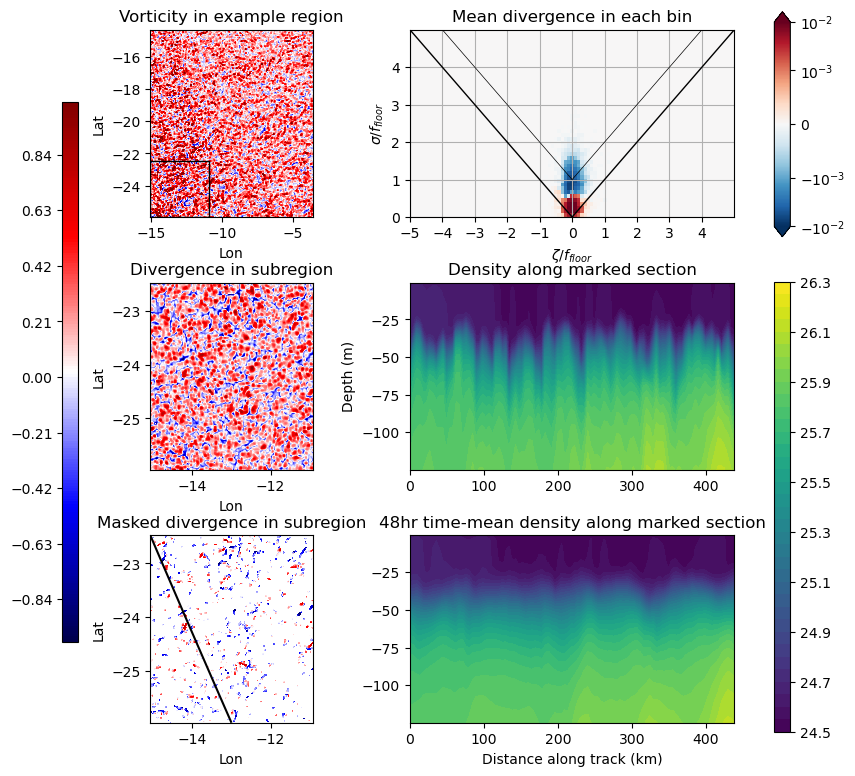

In [39]:
import matplotlib.patches as patches
fig3 = plt.figure(figsize=(8,9))
gs = fig3.add_gridspec(3,2,width_ratios=[1,2])


fig3.add_subplot(gs[0, 0])
plt.contourf(lon_piece,lat_piece,ζ_piece.values, levels=np.arange(-1,1.05,0.01)*0.5, cmap='seismic')

plt.title('Vorticity in example region')
rect = patches.Rectangle((lon_piece.isel(i=0).values, lat_piece.isel(j=0).values), 4.17, 3.5, linewidth=1, edgecolor='k', facecolor='none')
plt.xlabel('Lon')
plt.ylabel('Lat')

# Add the patch to the Axes
plt.gca().add_patch(rect)



fig3.add_subplot(gs[0, 1])
cs1=h_DivPdf.plot.pcolormesh(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)

#h_vort_strain.plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.title('Mean divergence in each bin')
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=1)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=1)
plt.plot(np.linspace(0,4), np.linspace(1,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-4,0), np.linspace(5,1),color='k',linewidth=0.5)

plt.xlabel('$\zeta/f_{floor}$')
plt.ylabel('$\sigma/f_{floor}$')
plt.grid()

x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)

plt.gca().set_xticks(x_ticks)

plt.gca().set_yticks(y_ticks)

cbar_ax2 = fig3.add_axes([0.9, 0.65, 0.02, 0.25])
fig3.colorbar(cs1, cax=cbar_ax2,extend='both')

fig3.add_subplot(gs[1, 0])
plt.contourf(lon_piece.isel(i=slice(0,200)),lat_piece.isel(j=slice(0,200)),D_piece.isel(i=slice(0,200)).isel(j=slice(0,200)).values, levels=np.arange(-1,1.05,0.01), cmap='seismic')
plt.title('Divergence in subregion')
plt.xlabel('Lon')
plt.ylabel('Lat')

fig3.add_subplot(gs[2, 0])
cs = plt.contourf(lon_piece.isel(i=slice(0,200)),lat_piece.isel(j=slice(0,200)),D_histrain.isel(i=slice(0,200)).isel(j=slice(0,200)).values, levels=np.arange(-1,1.05,0.01), cmap='seismic')
plt.title('Masked divergence in subregion')
plt.plot(x1,y1,color='k')
plt.xlabel('Lon')
plt.ylabel('Lat')

plt.subplots_adjust(hspace=0.35, wspace=0.4,right=0.85,left=0.12)
cbar_ax = fig3.add_axes([0.01, 0.2, 0.02, 0.6])
fig3.colorbar(cs, cax=cbar_ax,extend='both', location='left')


fig3.add_subplot(gs[1, 1])
cs = plt.contourf(total_dist, ds_TS.Z.values[0:24], pd0[0:24,:]-1000,levels=np.arange(24.5,26.3,0.05))
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Density along marked section')

fig3.add_subplot(gs[2, 1])
plt.contourf(total_dist, ds_TS.Z.values[0:24], (ds_TS_tm.time_mean_pd0[:,0:24]-1000).values.T,levels=np.arange(24.5,26.3,0.05))
#.plot.contourf(x='xdist',levels=np.arange(24.5,26.3,0.05),add_colorbar=False)
plt.xlabel('Distance along track (km)')
plt.title('48hr time-mean density along marked section')

cbar_ax = fig3.add_axes([0.9, 0.1, 0.02, 0.5])
fig3.colorbar(cs, cax=cbar_ax,extend='both')



plt.gcf().savefig('region_loc.png')
#plt.show()

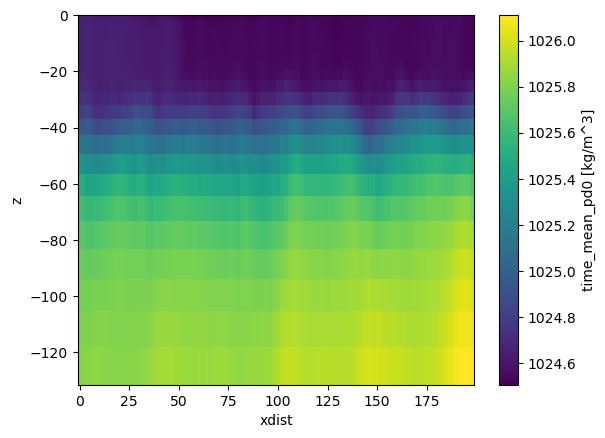

In [65]:
ds_TS_tm.time_mean_pd0[:,0:24].plot(x='xdist')

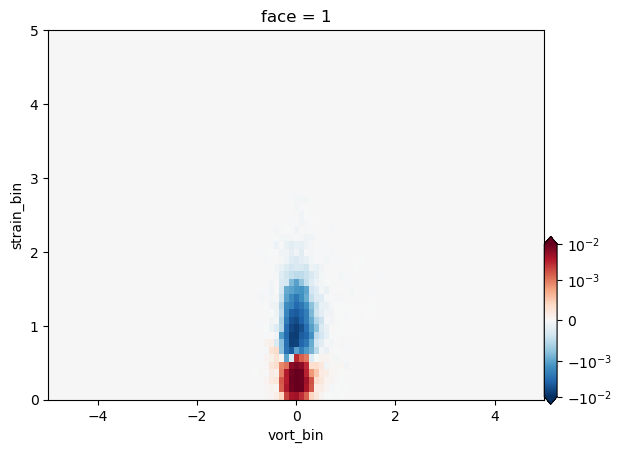

In [63]:
fig = plt.figure()
cs1=h_DivPdf.plot.pcolormesh(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
cbar_ax2 = fig.add_axes([0.9, 0.1, 0.02, 0.35])
plt.gcf().colorbar(cs1, cax=cbar_ax2,extend='both')

In [ ]:
cs = plt.contourf(lon_piece.isel(i=slice(0,200)),lat_piece.isel(j=slice(0,200)),D_piece.where((σ_piece>0.4)).isel(i=slice(0,200)).isel(j=slice(0,200)).values, levels=np.arange(-1,1.05,0.01), cmap='seismic')
plt.plot(lon_piece.isel(i=slice(0,100)), lat_piece.isel(j=slice(0,200))[-1::-2])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Divergence in subregion \n masked to only show areas \n where strain >0.4f')
plt.gcf().savefig('slice.png')

In [41]:
lon_piece.isel(i=slice(0,100))

<xarray.DataArray 'XC' (i: 100)> Size: 400B
dask.array<getitem, shape=(100,), dtype=float32, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
    face     int64 8B 1
  * i        (i) int64 800B 1100 1101 1102 1103 1104 ... 1196 1197 1198 1199

In [32]:
ds.sel(face=1).isel(i=slice(1100,1650)).isel(j=slice(2200,2850)).YC.min().values
#3.6+7.8

array(-25.9547, dtype=float32)

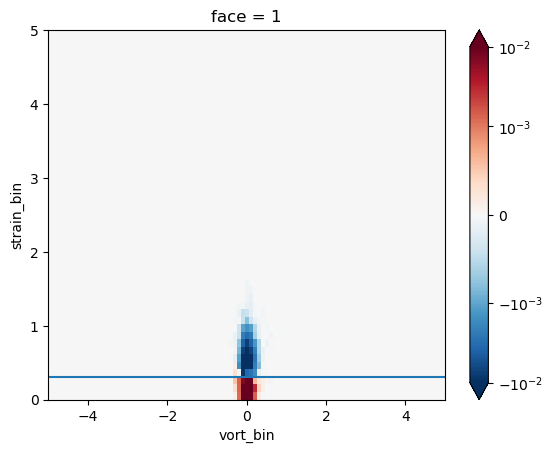

In [33]:
h_DivPdf.plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3))
plt.axhline(0.3)
#plt.axhline(1)
plt.gcf().savefig('jpdf_region.png')

In [43]:
h_DivPdf

<xarray.DataArray (vort_bin: 99, strain_bin: 49)> Size: 39kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * vort_bin    (vort_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
  * strain_bin  (strain_bin) float64 392B 0.05102 0.1531 0.2551 ... 4.847 4.949
    face        int64 8B 1

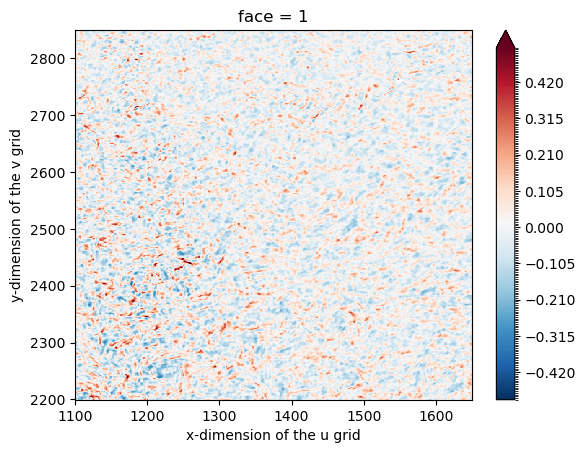

In [52]:
ζ_piece.plot(levels=np.arange(-1,1.05,0.01)*0.5)
plt.gcf().savefig('vort_region.png')

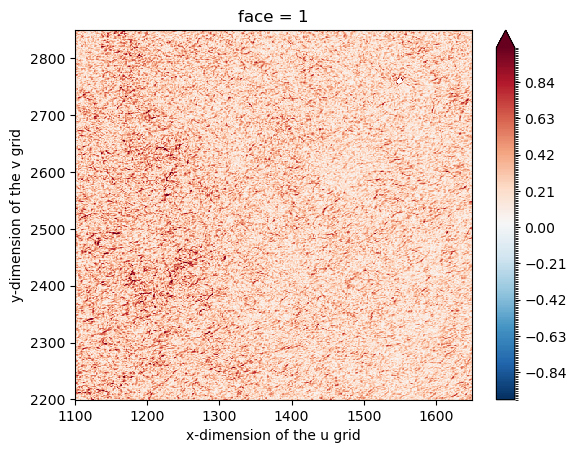

In [53]:
σ_piece.plot(levels=np.arange(-1,1.05,0.01))
plt.gcf().savefig('strain_region.png')

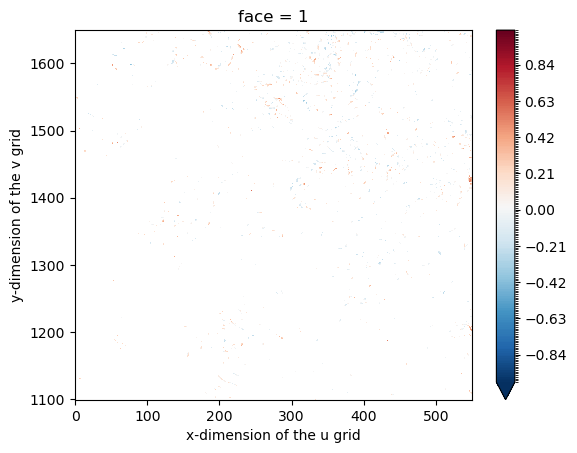

In [110]:
ζ_piece.where((σ_piece>0.5)&(σ_piece<1)).plot(levels=np.arange(-1,1.05,0.01))

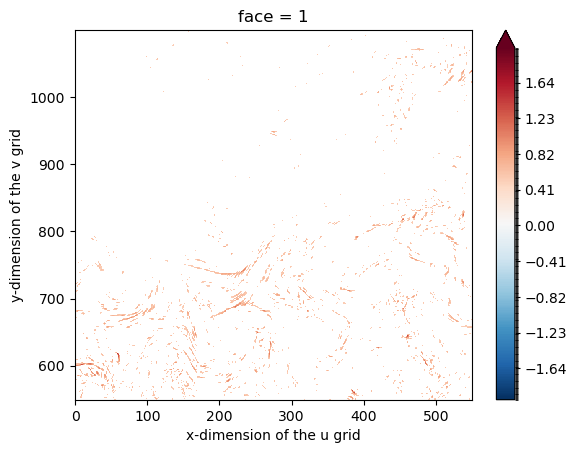

In [79]:
σ_piece.where((σ_piece>0.5)&(σ_piece<1).plot(levels=np.arange(-2,2.05,0.01))

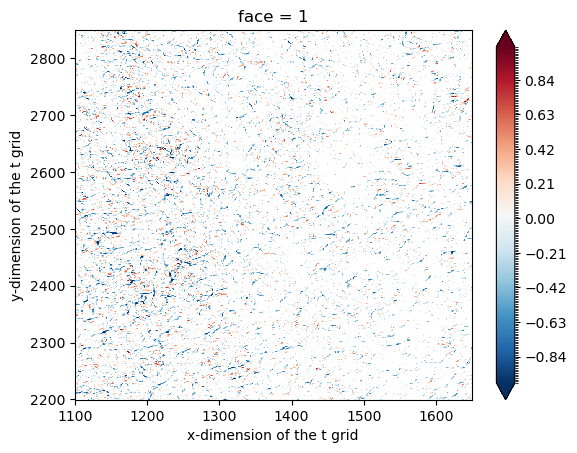

In [34]:
D_piece.where((σ_piece>0.4)).plot(levels=np.arange(-1,1.05,0.01))

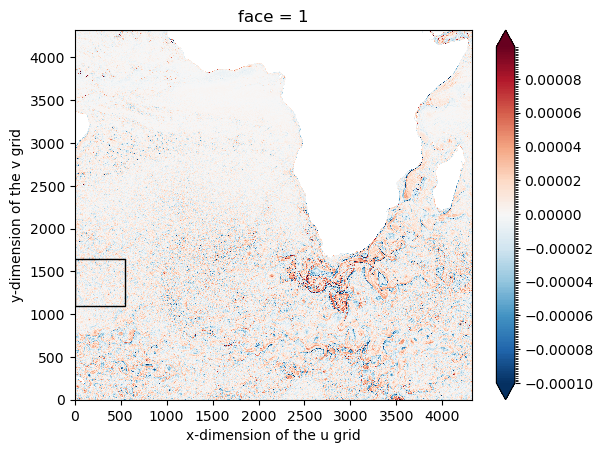

In [94]:
## Make gifs

In [48]:
σ_piece2 = σ.isel(time=slice(2736, 2786)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/10**-4
ζ_piece2 = ζ.isel(time=slice(2736, 2786)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
D_piece2 = D.isel(time=slice(2736, 2786)).sel(face=1).isel(i=slice(0,550)).isel(j=slice(1100,1650))/10**-4

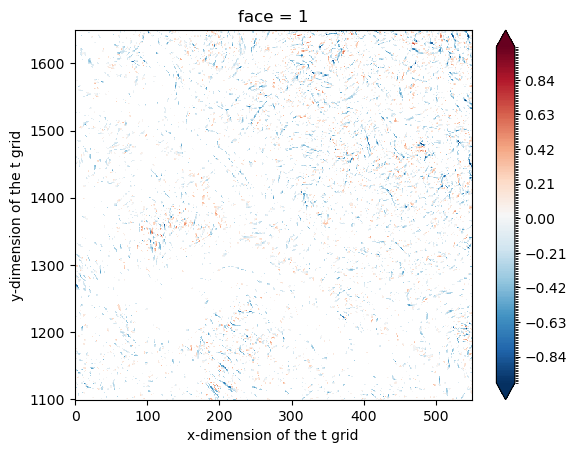

In [49]:
for t in range(0,50):
    plt.clf()
    D_piece2.where(σ_piece2>0.3).isel(time=t).plot(levels=np.arange(-1,1.05,0.01))
    plt.gcf().savefig('div_piece_movie/div_movie_n_%02d.png' % (t))

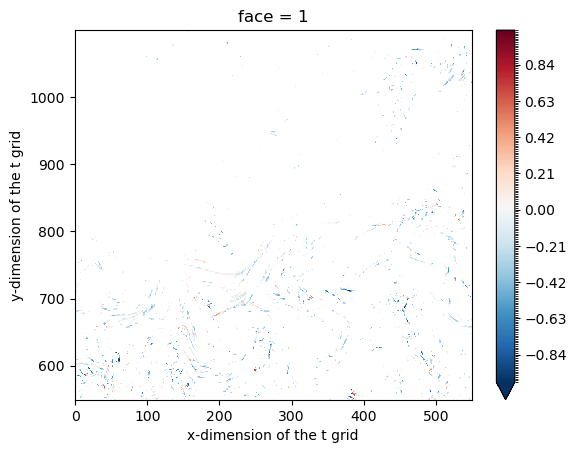

In [101]:
t=0
D_piece2.where((σ_piece2>0.5)&(σ_piece2<1)).isel(time=t).plot(levels=np.arange(-1,1.05,0.01))